<a href="https://colab.research.google.com/github/kmartellluya/fall_22_520_ML_Fairness_Toolkit/blob/main/520_VerifyML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install verifyml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install tempeh
from tempeh.configurations import datasets
compas_dataset = datasets["compas"]()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import pandas as pd
X_train, X_test = compas_dataset.get_X(format=pd.DataFrame)
y_train, y_test = compas_dataset.get_y(format=pd.Series)

X_train.loc[0], y_train[0]

(age                        25.000000
 juv_fel_count               0.000000
 juv_misd_count             -2.340451
 juv_other_count             1.000000
 priors_count              -15.010999
 age_cat_25 - 45             1.000000
 age_cat_Greater than 45     0.000000
 age_cat_Less than 25        0.000000
 c_charge_degree_F           0.000000
 c_charge_degree_M           1.000000
 Name: 0, dtype: float64, 1.0)

In [ ]:
import verifyml.model_card_toolkit as mctlib

# Initialize the Model Card Toolkit with a path to store generate assets
mct = mctlib.ModelCardToolkit(output_dir="model_card_output", file_name="compas_model_card")
model_card = mct.scaffold_assets()

In [8]:
!pip install responsibly`````

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 28.2 MB 52.9 MB/s 
     |████████████████████████████████| 23.4 MB 1.5 MB/s 
     |████████████████████████████████| 36.7 MB 1.2 MB/s 
  Created wheel for gensim: filename=gensim-3.7.3-cp38-cp38-linux_x86_64.whl size=25861686 sha256=209245c101844c74c5efec6dd697a061c0dd571c430ed032cbb2878a22e91b07
  Stored in directory: /root/.cache/pip/wheels/dd/a5/27/d48d7feb5a01ddba1a11f9be5cc84a2853862b353e71938dae
  Created wheel for matplotlib: filename=matplotlib-2.2.5-cp38-cp38-linux_x86_64.whl size=10811632 sha256=ca4e0f283ff392dee8331c7963c336e284aecabb1a0754cf35f86fce92437fe3
  Stored in directory: /root/.cache/pip/wheels/26/dc/65/d27080ab002cb70bcc99bae054a4ad6b6ae24e8e2b1c472d34
Successfully built gensim matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully un

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pylab as plt
import seaborn as sns

from responsibly.dataset import COMPASDataset
from responsibly.fairness.metrics import distplot_by

In [2]:
compas_ds = COMPASDataset()
df = compas_ds.df

len(df)

6172

In [3]:
df['race'].value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

In [4]:
(((df['race'].value_counts() / len(df))
  * 100)
 .round(2))

African-American    51.44
Caucasian           34.07
Hispanic             8.25
Other                5.56
Asian                0.50
Native American      0.18
Name: race, dtype: float64

In [5]:
pd.crosstab(df['sex'], df['race'])

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
sex,,,,,,
Female,549,2,482,82,2,58
Male,2626,29,1621,427,9,285


In [6]:
import verifyml.model_card_toolkit as mctlib

# Initialize the Model Card Toolkit with a path to store generate assets
mct = mctlib.ModelCardToolkit(output_dir="model_card_output", file_name="compas_model_card")
model_card = mct.scaffold_assets()

In [9]:
# You can add free text fields
model_card.model_details.name = 'Compass Dataset'


In [12]:


import json
from IPython import display
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, precision_score, recall_score
from sklearn.pipeline import Pipeline


import verifyml.model_card_toolkit as mctlib
from verifyml.model_card_toolkit import model_card_pb2, ModelCard
from verifyml.model_tests.utils import plot_to_str
from verifyml.model_tests.FEAT import (
    SubgroupDisparity,
    MinMaxMetricThreshold,
    Perturbation,
    SHAPFeatureImportance,
    FeatureImportance,
    DataShift
)



In [47]:
#x = df.drop(["two_year_recid","dob","compas_screening_date","v_screening_date","in_custody","out_custody","c_jail_in","c_jail_out","c_offense_date","c_arrest_date"
#,"r_offense_date","r_jail_in","r_jail_out","vr_offense_date","screening_date",],axis=1)
x=df[['age','race','sex']]
y = df["two_year_recid"]


# Train-Test data Split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.5, random_state=50
)


## Build ML model with protected attributes as model features

# Apply one hot encoding to categorical columns (auto-detect object columns) and random forest model in the pipeline
estimator = Pipeline(steps=[('onehot', ce.OneHotEncoder(use_cat_names=True)),
                      ('classifier', RandomForestClassifier(n_estimators=2, max_features="sqrt", random_state = 88))])


# Fit, predict and compute performance metrics
estimator.fit(x_train, y_train)

output = x_test.copy() # x_test df with output columns, to be appended later
y_pred = estimator.predict(x_test)
y_probas = estimator.predict_proba(x_test)[::, 1]

precision_train = round(precision_score(y_train, estimator.predict(x_train)),3)
recall_train = round(recall_score(y_train, estimator.predict(x_train)), 3)
precision_test = round(precision_score(y_test, y_pred),3)
recall_test = round(recall_score(y_test, y_pred), 3)


# Add output columns to this dataframe, to be used as a input for feat tests
output["truth"] = y_test
output["prediction"] = y_pred
output["prediction_probas"] = y_probas


# Dataframe with categorical features encoded
x_train_encoded = estimator[0].transform(x_train)
x_test_encoded = estimator[0].transform(x_test)


# Get feature importance values
df_importance = pd.DataFrame(
    {"features": x_test_encoded.columns, "value": estimator[-1].feature_importances_}
)


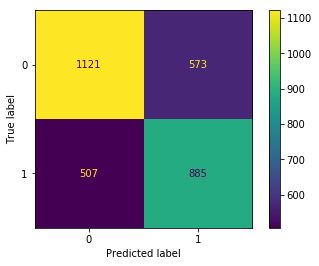

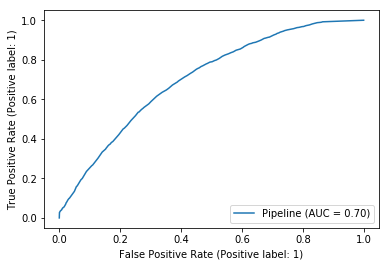

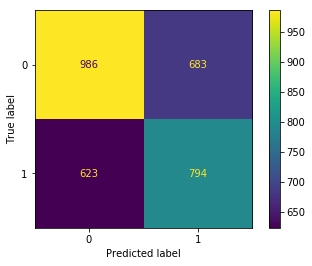

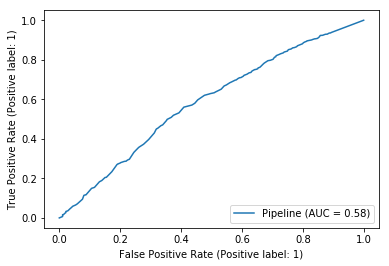

In [50]:

# Train set
ConfusionMatrixDisplay.from_estimator(estimator, x_train, y_train)
confusion_matrix_train = plot_to_str()
RocCurveDisplay.from_estimator(estimator, x_train, y_train)
roc_curve_train = plot_to_str()

# Test set
ConfusionMatrixDisplay.from_estimator(estimator, x_test, y_test)
confusion_matrix_test = plot_to_str()
RocCurveDisplay.from_estimator(estimator, x_test, y_test)
roc_curve_test = plot_to_str()


In [48]:

from verifyml.model_tests.FEAT import SubgroupDisparity
df['truth'] = df['two_year_recid']
df['prediction'] = np.random.randint(2, size=6172)
sgd_test = SubgroupDisparity(
    attr='race',
    metric='fpr',
    method='ratio',
    threshold=2,  
)
sgd_test.run(df)

True

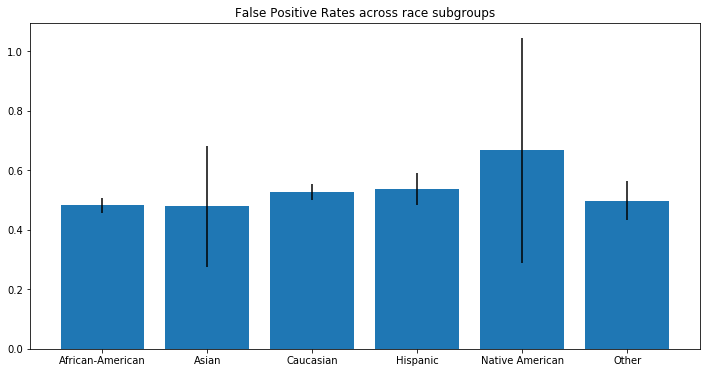

In [49]:

sgd_test.plot()

In [20]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(df['truth'], df['prediction'])

TN, FP, FN, TP = confusion_matrix(df['truth'], df['prediction']).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

True Positive(TP)  =  1360
False Positive(FP) =  1694
True Negative(TN)  =  1669
False Negative(FN) =  1449


In [21]:
accuracy =  (TP + TN) / (TP + FP + TN + FN)

print('Accuracy of the binary classifier = {:0.3f}'.format(accuracy))

Accuracy of the binary classifier = 0.491


In [38]:
from verifyml.model_tests.FEAT import MinMaxMetricThreshold
df['truth'] = df['two_year_recid']
df['prediction'] = np.random.randint(2, size=6172)
min_max_test = MinMaxMetricThreshold(
    attr='sex',
    metric='mae',
    threshold=0.025
)
min_max_test.run(df)

False

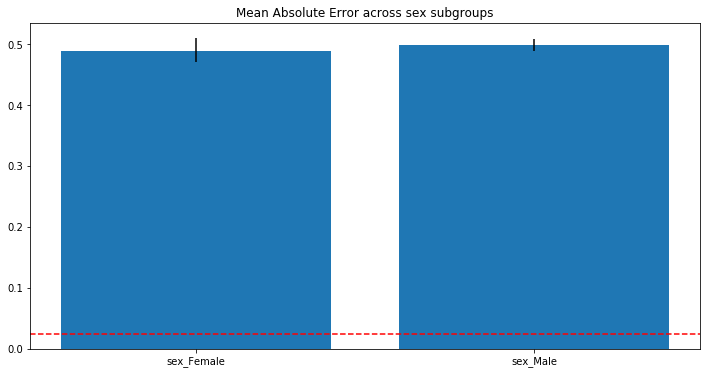

In [39]:
min_max_test.plot()